## Import needed packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

## Hyperparameter


In [3]:
config = {
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "batch_size" : 64,
    "learning_rate" : 0.01 ,
    "epochs":15,
}

## Dataloader

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True)

## Visualize


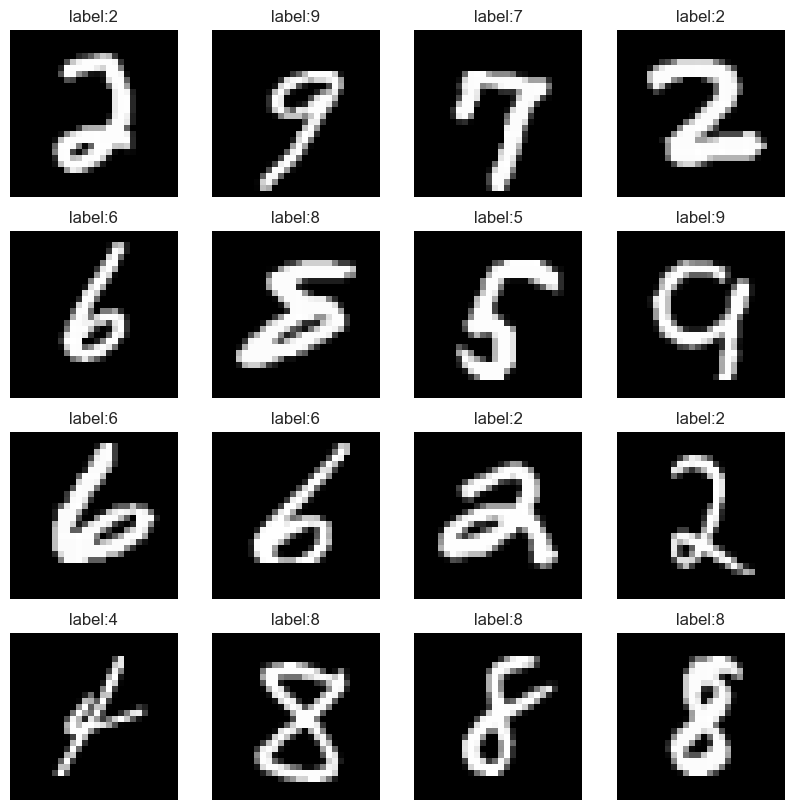

In [5]:
examples = iter(train_loader)
images, labels = next(examples)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i][0], cmap='gray')
    # plt.title(f"Label: {labels[i].item()}")
    plt.title(f"label:{labels[i]}")
    plt.axis('off')
plt.show()


## Model


In [6]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # 28x28 → 28x28
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),                              # 28x28 → 14x14

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 14x14 → 14x14
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),                              # 14x14 → 7x7
        )

        self.fc = nn.Sequential(
            nn.Flatten(),                                 # 展平为 64 * 7 * 7
            nn.Linear(64 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(128, 10)                            # 输出层
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = SimpleNN().to(config["device"])


In [9]:
from torchsummary import summary

summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         LeakyReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
       BatchNorm2d-6           [-1, 64, 14, 14]             128
         LeakyReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
           Flatten-9                 [-1, 3136]               0
           Linear-10                  [-1, 128]         401,536
      BatchNorm1d-11                  [-1, 128]             256
        LeakyReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

## Loss Function and Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

## Trainig loop

In [11]:
from tqdm import tqdm

best_acc = 0.0  # 当前最优准确率

for epoch in range(config["epochs"]):
    total_loss = 0.0
    model.train()

    print(f"\n🔄 Epoch {epoch+1}/{config['epochs']}")
    train_bar = tqdm(train_loader, desc="Training", dynamic_ncols=True, leave=False)

    for images, labels in train_bar:
        images, labels = images.to(config["device"]), labels.to(config["device"])

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1} finished. Average Loss: {avg_loss:.4f}")

    # =============== 验证集评估（可用 test_loader） ===============
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(config["device"]), labels.to(config["device"])
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    print(f"📊 Test Accuracy after Epoch {epoch+1}: {acc*100:.2f}%")

    # =============== 保存最好的模型 ===============
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_model.pth")
        print("💾 Saved new best model!")

print(f"\n🏁 Training done. Best Accuracy: {best_acc*100:.2f}%")



🔄 Epoch 1/15


✅ Epoch 1 finished. Average Loss: 0.1167
📊 Test Accuracy after Epoch 1: 98.49%
💾 Saved new best model!

🔄 Epoch 2/15


✅ Epoch 2 finished. Average Loss: 0.0554
📊 Test Accuracy after Epoch 2: 98.60%
💾 Saved new best model!

🔄 Epoch 3/15


✅ Epoch 3 finished. Average Loss: 0.0448
📊 Test Accuracy after Epoch 3: 98.91%
💾 Saved new best model!

🔄 Epoch 4/15


✅ Epoch 4 finished. Average Loss: 0.0380
📊 Test Accuracy after Epoch 4: 98.96%
💾 Saved new best model!

🔄 Epoch 5/15


✅ Epoch 5 finished. Average Loss: 0.0361
📊 Test Accuracy after Epoch 5: 98.97%
💾 Saved new best model!

🔄 Epoch 6/15


✅ Epoch 6 finished. Average Loss: 0.0304
📊 Test Accuracy after Epoch 6: 98.87%

🔄 Epoch 7/15


✅ Epoch 7 finished. Average Loss: 0.0260
📊 Test Accuracy after Epoch 7: 99.11%
💾 Saved new best model!

🔄 Epoch 8/15


✅ Epoch 8 finished. Average Loss: 0.0248
📊 Test Accuracy after Epoch 8: 98.98%

🔄 Epoch 9/15


✅ Epoch 9 finished. Average Loss: 0.0255
📊 Test Accuracy after Epoch 9: 99.01%

🔄 Epoch 10/15


✅ Epoch 10 finished. Average Loss: 0.0197
📊 Test Accuracy after Epoch 10: 99.23%
💾 Saved new best model!

🔄 Epoch 11/15


✅ Epoch 11 finished. Average Loss: 0.0207
📊 Test Accuracy after Epoch 11: 99.16%

🔄 Epoch 12/15


✅ Epoch 12 finished. Average Loss: 0.0209
📊 Test Accuracy after Epoch 12: 99.19%

🔄 Epoch 13/15


✅ Epoch 13 finished. Average Loss: 0.0170
📊 Test Accuracy after Epoch 13: 99.24%
💾 Saved new best model!

🔄 Epoch 14/15


✅ Epoch 14 finished. Average Loss: 0.0167
📊 Test Accuracy after Epoch 14: 99.19%

🔄 Epoch 15/15


✅ Epoch 15 finished. Average Loss: 0.0159
📊 Test Accuracy after Epoch 15: 99.20%

🏁 Training done. Best Accuracy: 99.24%


## Testing

In [12]:
with torch.no_grad():
    total = 0
    correct = 0
    model.eval()
    for images, labels in tqdm(test_loader, desc="Testing", dynamic_ncols=True, leave=False):
        images, labels = images.to(config["device"]),labels.to(config["device"])
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.20%


## Saving Model

In [13]:
# torch.save(model.state_dict(), "model.pth")

## Load Model and Predict

In [14]:
model.load_state_dict(torch.load("model.pth"))
model.eval()

images, labels = next(iter(test_loader))
images, labels = images.to(config["device"]),labels.to(config["device"])
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.20%


## Visualize

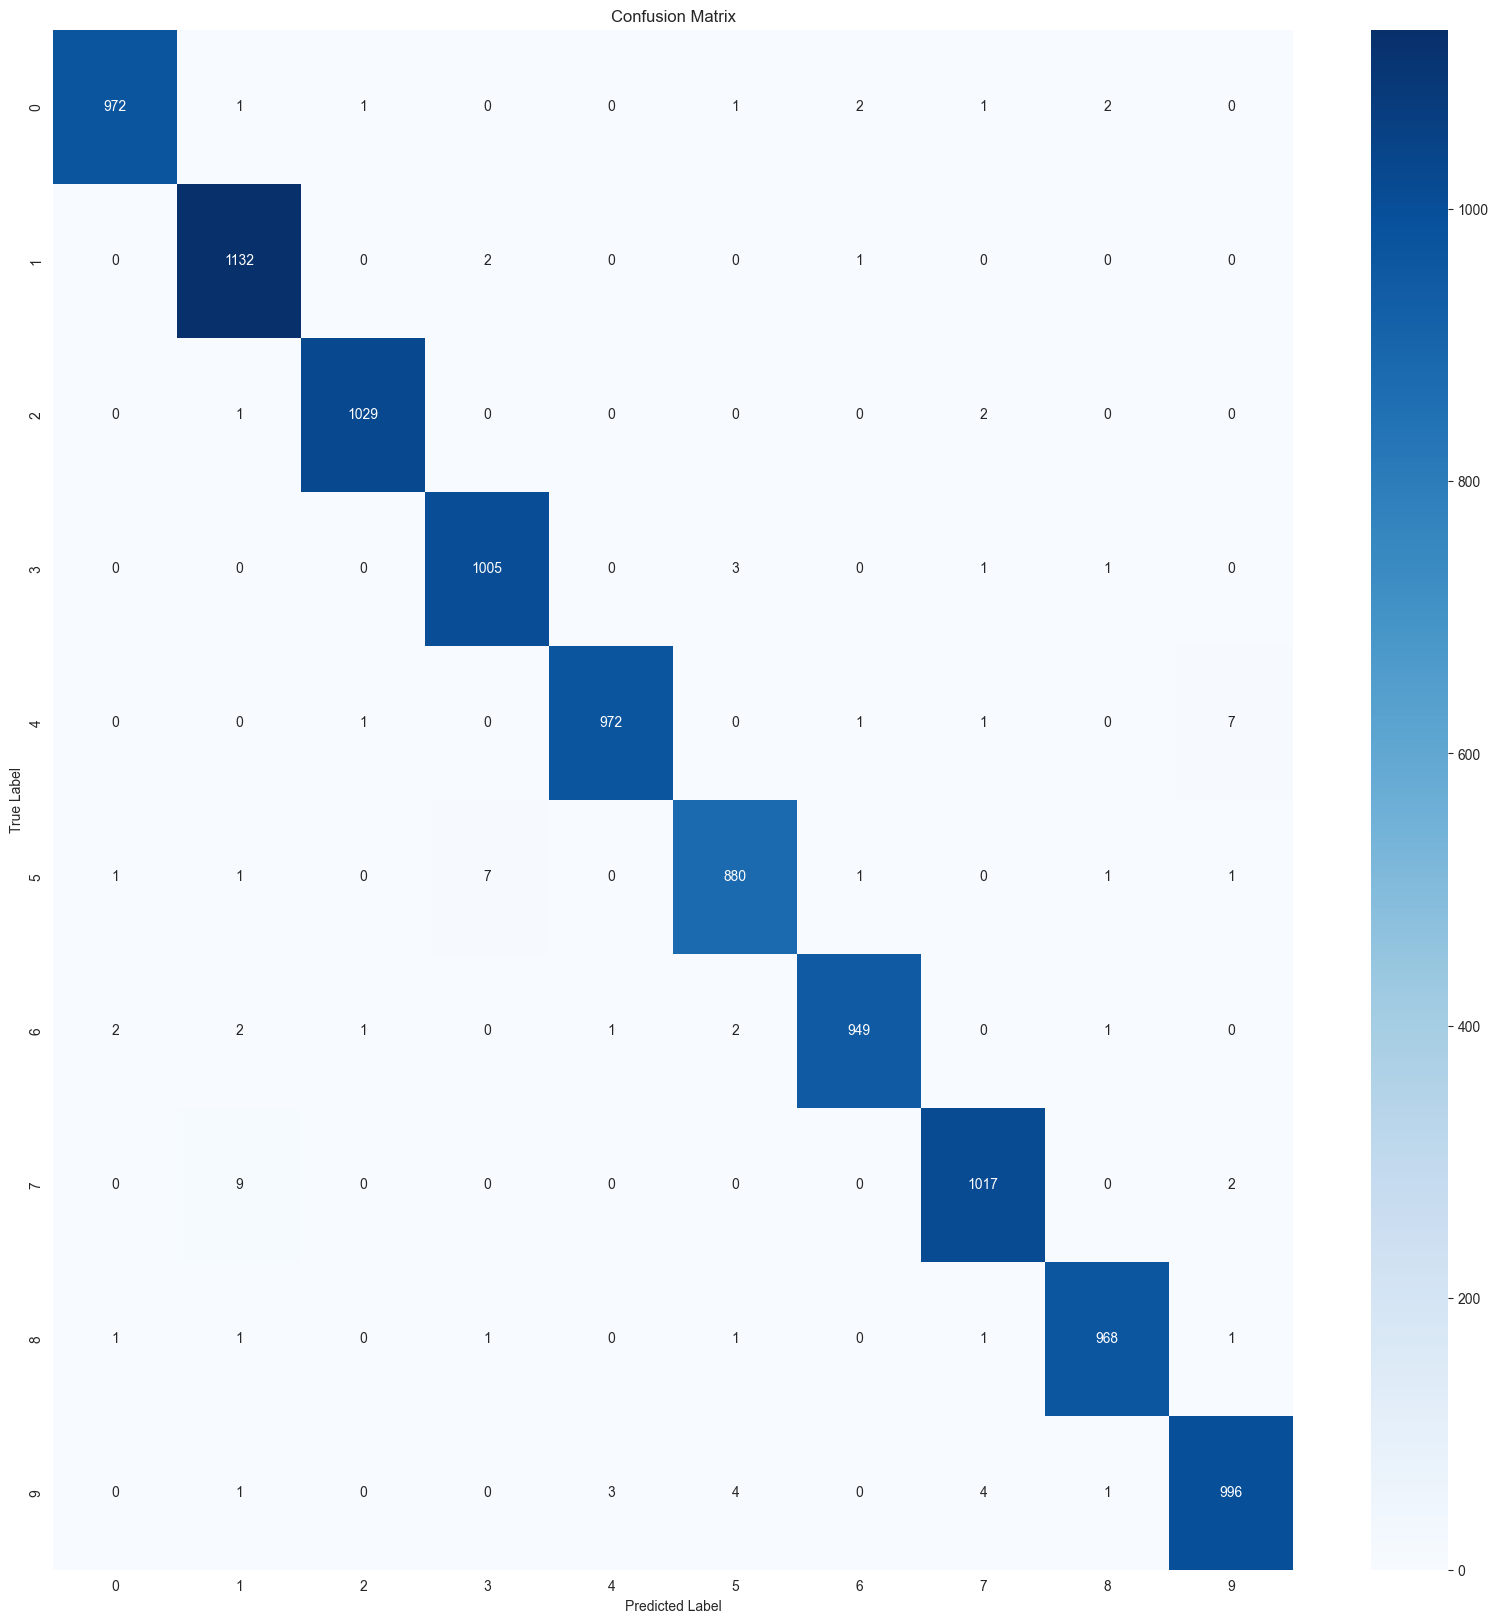

In [15]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(config["device"]), labels.to(config["device"])
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# calculate
cm = confusion_matrix(all_labels, all_preds)

# Visualize
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
